In [1]:
import geopandas as gpd
from geopandas.tools import sjoin
import pandas as pd
import requests
import json
from pprint import pprint
from config import gkey
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
from itertools import compress

In [2]:
cdmx_gdp=gpd.read_file('data/shapes/09m.shp')

In [3]:
gam_gdp=cdmx_gdp[cdmx_gdp['CVE_MUN']=='005']
gam_gdp.head()

,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,geometry
13705,09,005,0001,1148,008,Típica,"POLYGON ((2802682.728 835673.649, 2802672.945 ..."
13706,09,005,0001,1152,018,Típica,"POLYGON ((2803015.393 835770.018, 2802994.766 ..."
13707,09,005,0001,1148,010,Típica,"POLYGON ((2802748.907 835754.125, 2802780.251 ..."
13708,09,005,0001,1148,007,Típica,"POLYGON ((2802668.317 835705.970, 2802677.191 ..."
13709,09,005,0001,1148,012,Típica,"POLYGON ((2802934.098 835634.631, 2802880.177 ..."


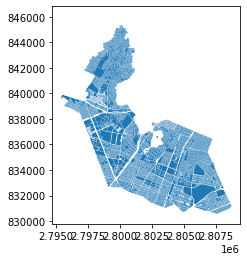

In [4]:
gam_gdp.plot()

In [5]:
gam_gps=pd.read_csv('data/GMcoords.csv')
#gam_gps.head()

In [6]:
geometry =[Point(xy) for xy in zip(gam_gps['lon'],gam_gps['lat'])]
crs={'init':'epsg:4326'}
points_gpd=gpd.GeoDataFrame(gam_gps,crs=crs,geometry=geometry)

In [7]:
points_gpd.head()

,Unnamed: 0,attributes,price,status,adress,lat,lon,geometry
0,0,200 m² construidos | 3 recs.,"2,300,000",Casa en venta,Gustavo A. Madero - Distrito Federal,19.487333,-99.123613,POINT (-99.12361 19.48733)
1,1,320 m² construidos | 3 recs.,"8,500,000",Casa en venta,Ambato - Lindavista Norte - Gustavo A. Madero...,19.500071,-99.128877,POINT (-99.12888 19.50007)
2,2,278 m² construidos | 4 recs.,"65,500",Casa en venta,CALLE 625 00 - San Antonio - Gustavo A. Mader...,19.453837,-99.065769,POINT (-99.06577 19.45384)
3,3,160 m² construidos | 3 recs.,"1,499,000",Casa en venta,641 227 - San Juan De Aragón 4a Secc. - Gusta...,19.459747,-99.065156,POINT (-99.06516 19.45975)
4,4,210 m² construidos | 4 recs.,"685,000",Casa en venta,CAIRO 303 - Fernando Casas Alemán - Gustavo A...,19.452036,-99.096910,POINT (-99.09691 19.45204)


In [8]:
points_gpd.crs

{'init': 'epsg:4326'}

In [9]:
# Changing CRS in GAM
gam_gdp = gam_gdp.to_crs({'init': 'epsg:4326'})
gam_gdp.crs

{'init': 'epsg:4326'}

In [26]:
points_with_gdp=sjoin(points_gpd,gam_gdp,how='left')

In [27]:
bounderies=gam_gdp.geometry.bounds

In [28]:
list(bounderies)

['minx', 'miny', 'maxx', 'maxy']

In [29]:
min_x=bounderies['minx'].min()
min_y=bounderies['miny'].min()
max_x=bounderies['maxx'].max()
max_y=bounderies['maxy'].max()

In [30]:
points_with_gdp
cl=(~points_with_gdp['CVE_ENT'].isna())

points_with_gdp=points_with_gdp[cl]

In [31]:
points_with_gdp
points_with_gdp['id']=points_with_gdp['CVE_LOC']+points_with_gdp['CVE_AGEB']+points_with_gdp['CVE_MZA']

In [34]:
points_with_gdp
cl=(points_with_gdp['lat']>max_y)|(points_with_gdp['lat']<min_y)|(points_with_gdp['lon']>max_x)|(points_with_gdp['lon']<min_x)
points_with_gdp=points_with_gdp[~cl]

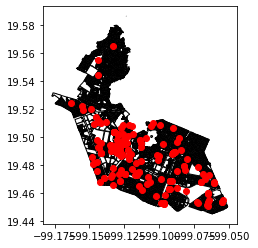

In [35]:
ax = gam_gdp.plot(color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
points_with_gdp.plot(ax=ax, color='red')

plt.show()

In [37]:
#df.astype({'col1': 'int32'})
points_with_gdp
#points_with_gdp['price_m2']=points_with_gdp['price']/points_with_gdp['m2']

,Unnamed: 0,attributes,price,status,adress,lat,lon,geometry,index_right,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,TIPOMZA,id
3,3,160 m² construidos | 3 recs.,"1,499,000",Casa en venta,641 227 - San Juan De Aragón 4a Secc. - Gusta...,19.459747,-99.065156,POINT (-99.06516 19.45975),20437.0,09,005,0001,2377,007,Típica,00012377007
4,4,210 m² construidos | 4 recs.,"685,000",Casa en venta,CAIRO 303 - Fernando Casas Alemán - Gustavo A...,19.452036,-99.096910,POINT (-99.09691 19.45204),15200.0,09,005,0001,2305,014,Típica,00012305014
5,5,180 m² construidos | 4 recs.,"4,100,000",Casa en venta,Avenida 414-A 229 - San Juan De Aragón 6a Sec...,19.469571,-99.066990,POINT (-99.06699 19.46957),19720.0,09,005,0001,199A,015,Típica,0001199A015
7,7,509 m² construidos | 5 recs.,"11,870,000",Casa en venta,Lindavista Norte 0 - Lindavista Norte - Gusta...,19.503769,-99.132428,POINT (-99.13243 19.50377),16549.0,09,005,0001,313A,017,Edificio-Manzana,0001313A017
7,7,509 m² construidos | 5 recs.,"11,870,000",Casa en venta,Lindavista Norte 0 - Lindavista Norte - Gusta...,19.503769,-99.132428,POINT (-99.13243 19.50377),16060.0,09,005,0001,313A,001,Contenedora,0001313A001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,387,195 m² construidos | 3 recs.,"647,008",Casa en venta,Salvador Carrillo 77 - C.T.M. Atzacoalco - Gu...,19.510221,-99.104424,POINT (-99.10442 19.51022),18005.0,09,005,0001,288A,009,Típica,0001288A009
390,390,63 m² construidos | 3 recs.,"1,850,000",Casa en venta,Cerrada de Nautla - Ampliación Casas Alemán -...,19.476079,-99.081750,POINT (-99.08175 19.47608),14354.0,09,005,0001,1913,004,Típica,00011913004
398,398,280 m² construidos | 4 recs.,"914,986",Casa en venta,CALLE 15 DE MAYO 32 - Planetario Lindavista -...,19.495936,-99.142071,POINT (-99.14207 19.49594),19617.0,09,005,0001,0934,018,Típica,00010934018
400,400,130 m² construidos | 3 recs.,"596,000",Casa en venta,313 0 - El Coyol - Gustavo A. Madero - Distri...,19.488131,-99.090086,POINT (-99.09009 19.48813),17431.0,09,005,0001,1311,003,Típica,00011311003
